**음악의 표현 방법**

In [1]:
import IPython.display as ipd
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import pretty_midi
import pandas as pd

from utils.plot_tools import color_argument_to_dict

기호/심볼릭(symbolic) 표현

- 기호(symbolic) 음악 표현이란 음표나 여타 음악 이벤트들을 명시적으로 인코딩한 모든 종류의 악보 표현을 의미한다.

# 피아노-롤(piano-roll) 표현

- 피아노-롤은 피아노와 관련된 노트 정보들을 모아 가시화한 것을 일반적으로 말한다.

- 드뷔시와 베토벤 음악의 피아노롤을 아래 영상과 같이 표현할 수 있다.

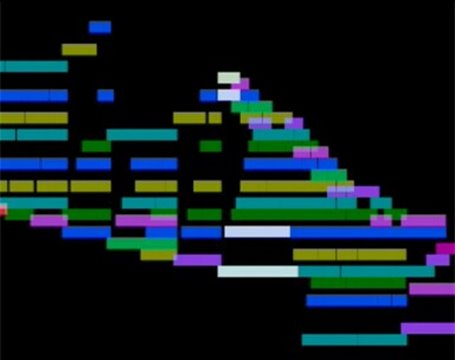

In [2]:
ipd.display( ipd.YouTubeVideo("LlvUepMa31o", start=15) )

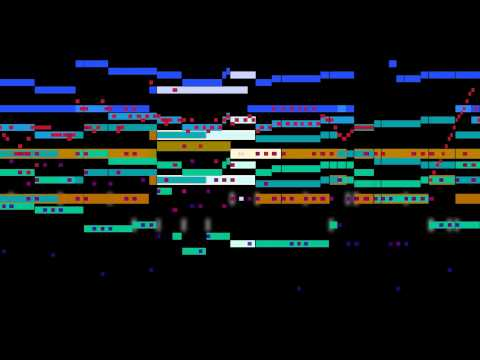

In [3]:
ipd.display( ipd.YouTubeVideo("Kri2jWr08S4", start=11) )

피아노-롤을 CSV파일로

# 미디 (MIDI) 표현

- 또다른 기호 표현으로는 MIDI(Musical Instrument Digital Interface) 스탠다드가 있다. MIDI는 1980년대 초반 전자 음악 악기 시장의 급성장과 함께 출현했다.

- MIDI 메시지는 음(note) 온셋, 음 오프셋, 강도(intensity or "velocity")와 같은 정보를 인코딩한다. 컴퓨터에서 MIDI 파일은 MIDI 메시지들과 다른 메타데이터를 보관한다.

- **MIDI  노트넘버**(MIDI note number)는 0과 127 사이의 정수로 노트의 피치를 인코딩한다. 가장 중요한 것으로는 C4(중간 C)는 MIDI 노트넘버 60이고, A4(concert A440)은 MIDI 노트넘버 69이다. MIDI 노트넘버는 12개로 나누어져있으며 한 옥타브씩 나누어진다 (e.g. 72 = C5, 84 = C6, etc.)

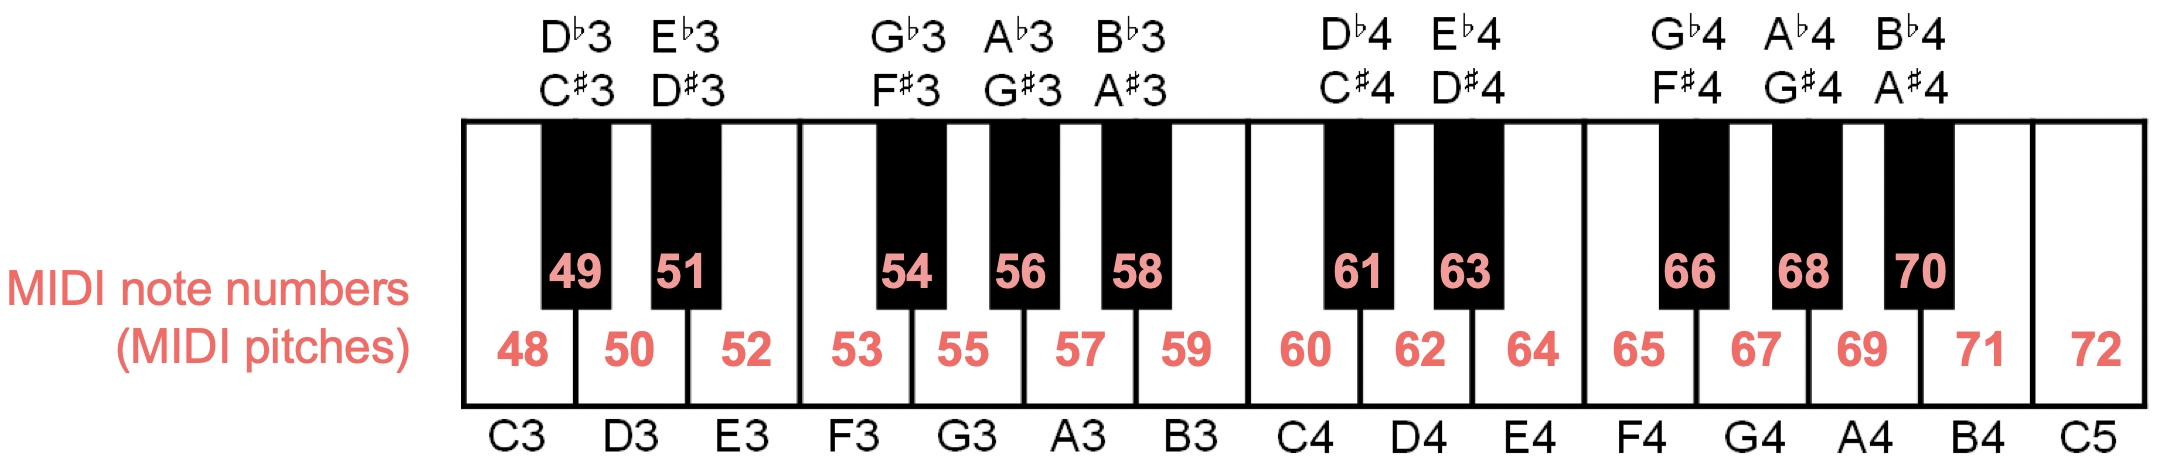

In [4]:
Image("../img/2.music_representation/FMP_C1_MIDI-NoteNumbers.png", width=500)

- **키 벨로시티**(key velocity)는 0과 127 사이의 정수로 소리의 강도를 조정한다.
- **MIDI 채널**은 0과 15 사이의 정수로 신디사이저가 특정 악기를 사용하도록 안내한다.

- MIDI는 사분음표를 **clock pulses** 또는 **틱**으로 세분화한다. 예를 들어, 분기 음 당 펄스 수(PPQN)를 120으로 정의하면 60개의 틱이 8번째 음의 길이를 나타낸다.
- 또한 MIDI는 템포를 **BPM**으로 인코딩하여 절대적인 시간 정보를 알려준다. 

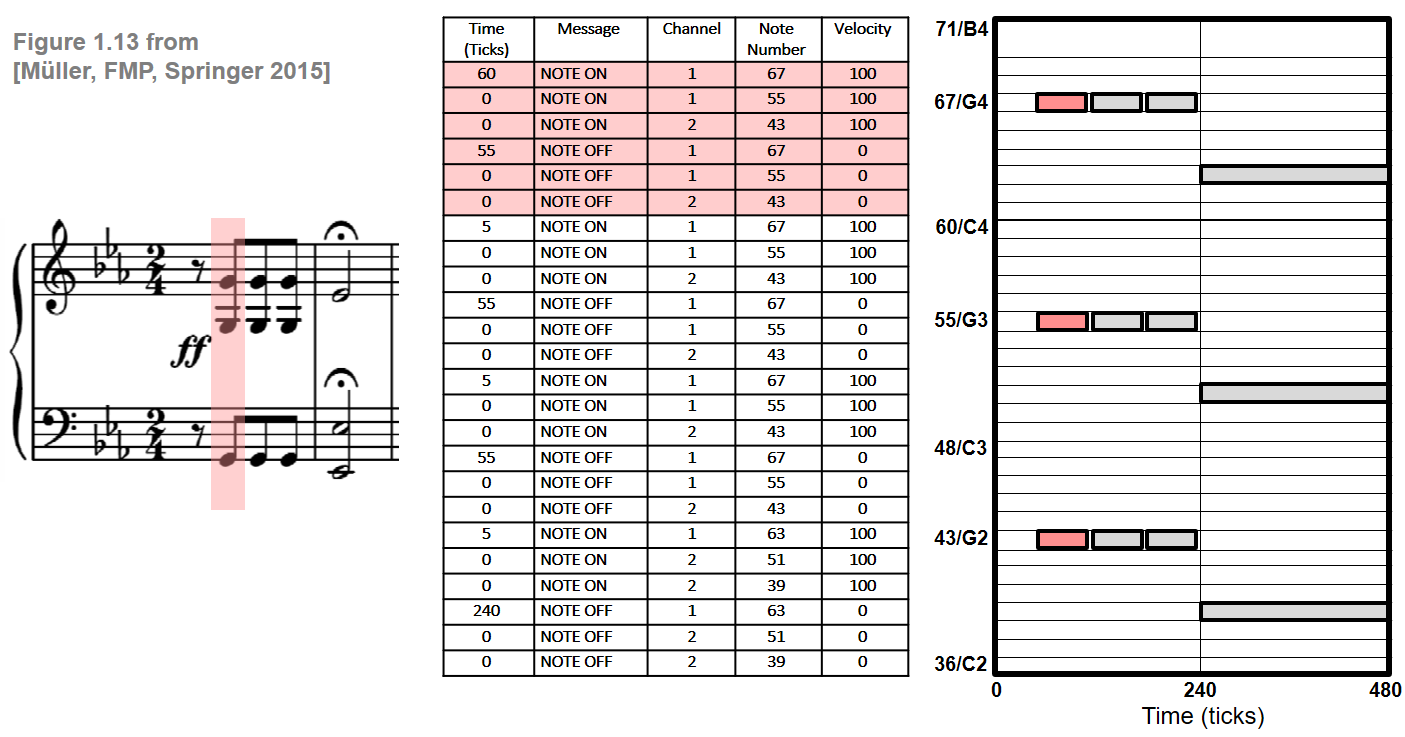

In [5]:
Image("../img/2.music_representation/FMP_C1_F13.png", width=600)

In [6]:
midi_data = pretty_midi.PrettyMIDI("../data_FMP/FMP_C1_F01_Beethoven_FateMotive_Sibelius-Tracks.mid")
midi_list = []

for instrument in midi_data.instruments:
    for note in instrument.notes:
        start = note.start
        end = note.end
        pitch = note.pitch
        velocity = note.velocity
        midi_list.append([start, end, pitch, velocity, instrument.name])
        
midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))

df = pd.DataFrame(midi_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
html = df.to_html(index=False)
ipd.HTML(html)

Start,End,Pitch,Velocity,Instrument
0.25,0.50,43,113,Piano
0.25,0.50,55,76,Piano
0.25,0.50,67,76,Piano
0.50,0.75,43,113,Piano
0.50,0.75,55,76,Piano
0.50,0.75,67,76,Piano
0.75,1.00,43,113,Piano
0.75,1.00,55,76,Piano
0.75,1.00,67,76,Piano
1.00,2.00,39,126,Piano


In [7]:
Fs = 22050
audio_data = midi_data.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)

In [8]:
def midi_to_list(midi):
    """Convert a midi file to a list of note events

    Args:
        midi (str or pretty_midi.pretty_midi.PrettyMIDI): Either a path to a midi file or PrettyMIDI object

    Returns:
        score (list): A list of note events where each note is specified as
            ``[start, duration, pitch, velocity, label]``
    """

    if isinstance(midi, str):
        midi_data = pretty_midi.pretty_midi.PrettyMIDI(midi)
    elif isinstance(midi, pretty_midi.pretty_midi.PrettyMIDI):
        midi_data = midi
    else:
        raise RuntimeError('midi must be a path to a midi file or pretty_midi.PrettyMIDI')

    score = []

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = note.start
            duration = note.end - start
            pitch = note.pitch
            velocity = note.velocity / 128.
            score.append([start, duration, pitch, velocity, instrument.name])
    return score

In [9]:
def visualize_piano_roll(score, xlabel='Time (seconds)', ylabel='Pitch', colors='FMP_1', velocity_alpha=False,
                         figsize=(12, 4), ax=None, dpi=72):
    """Plot a pianoroll visualization
    Args:
        score: List of note events
        xlabel: Label for x axis (Default value = 'Time (seconds)')
        ylabel: Label for y axis (Default value = 'Pitch')
        colors: Several options: 1. string of FMP_COLORMAPS, 2. string of matplotlib colormap,
            3. list or np.ndarray of matplotlib color specifications,
            4. dict that assigns labels  to colors (Default value = 'FMP_1')
        velocity_alpha: Use the velocity value for the alpha value of the corresponding rectangle
            (Default value = False)
        figsize: Width, height in inches (Default value = (12)
        ax: The Axes instance to plot on (Default value = None)
        dpi: Dots per inch (Default value = 72)
    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1, 1, 1)

    labels_set = sorted(set([note[4] for note in score]))
    colors = color_argument_to_dict(colors, labels_set)

    pitch_min = min(note[2] for note in score)
    pitch_max = max(note[2] for note in score)
    time_min = min(note[0] for note in score)
    time_max = max(note[0] + note[1] for note in score)

    for start, duration, pitch, velocity, label in score:
        if velocity_alpha is False:
            velocity = None
        rect = patches.Rectangle((start, pitch - 0.5), duration, 1, linewidth=1,
                                 edgecolor='k', facecolor=colors[label], alpha=velocity)
        ax.add_patch(rect)

    ax.set_ylim([pitch_min - 1.5, pitch_max + 1.5])
    ax.set_xlim([min(time_min, 0), time_max + 0.5])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_axisbelow(True)
    ax.legend([patches.Patch(linewidth=1, edgecolor='k', facecolor=colors[key]) for key in labels_set],
              labels_set, loc='upper right', framealpha=1)

    if fig is not None:
        plt.tight_layout()

    return fig, 

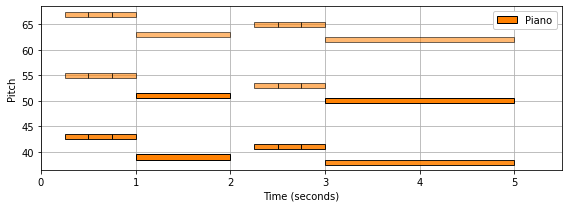

In [10]:
score = midi_to_list(midi_data)
visualize_piano_roll(score, figsize=(8, 3), velocity_alpha=True);

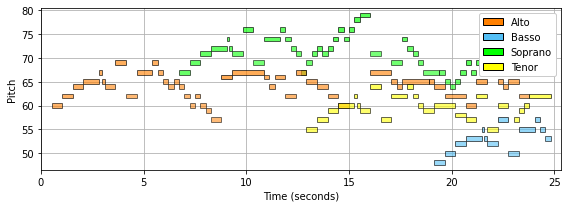

In [11]:
midi_data = pretty_midi.PrettyMIDI("../data_FMP/FMP_C1_F12_Bach_BWV846_Sibelius-Tracks.mid")
score = midi_to_list(midi_data)
visualize_piano_roll(score, figsize=(8, 3), velocity_alpha=True);

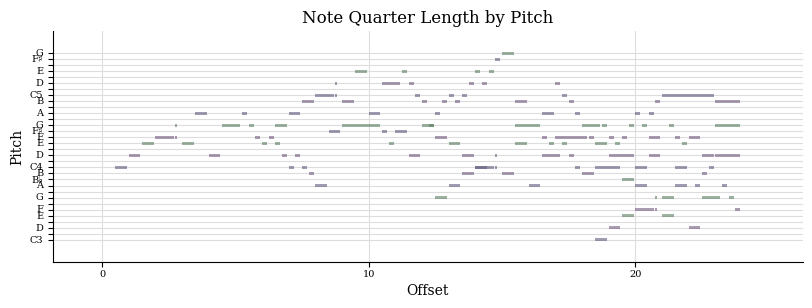

In [12]:
import music21 as m21

s = m21.converter.parse("../data_FMP/FMP_C1_F12_Bach_BWV846_Sibelius-Tracks.mid")
s.plot('pianoroll', figureSize=(10, 3))

# 악보적(score) 표현

- 기호 악보 표현은 "2.1.Sheet_Music.ipynb"에서 설명한 음악적 심볼들을 인코딩한다. (음자리표, 조표 등등)
하지만 이를 악보로 가시화하는 것이 아니라 저장하는데, **MusicXML**같은 파일이 있다.

- 아래 그 예시가 있다.

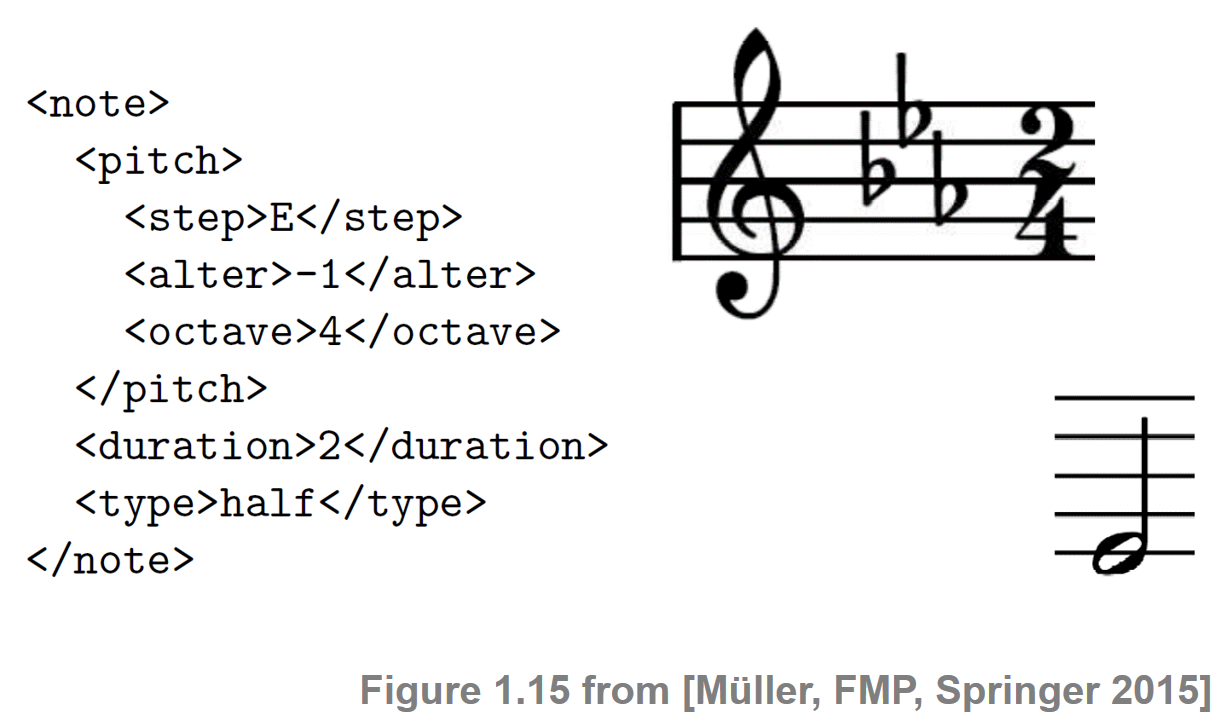

In [13]:
Image("../img/2.music_representation/FMP_C1_F15.png", width=400)

In [14]:
def xml_to_list(xml):
    """Convert a music xml file to a list of note events

    Args:
        xml (str or music21.stream.Score): Either a path to a music xml file or a music21.stream.Score

    Returns:
        score (list): A list of note events where each note is specified as
            ``[start, duration, pitch, velocity, label]``
    """

    if isinstance(xml, str):
        xml_data = m21.converter.parse(xml)
    elif isinstance(xml, m21.stream.Score):
        xml_data = xml
    else:
        raise RuntimeError('midi must be a path to a midi file or music21.stream.Score')

    score = []

    for part in xml_data.parts:
        instrument = part.getInstrument().instrumentName

        for note in part.flat.notes:

            if note.isChord:
                start = note.offset
                duration = note.quarterLength

                for chord_note in note.pitches:
                    pitch = chord_note.ps
                    volume = note.volume.realized
                    score.append([start, duration, pitch, volume, instrument])

            else:
                start = note.offset
                duration = note.quarterLength
                pitch = note.pitch.ps
                volume = note.volume.realized
                score.append([start, duration, pitch, volume, instrument])

    score = sorted(score, key=lambda x: (x[0], x[2]))
    return score

In [15]:
xml_data = m21.converter.parse("../data_FMP/FMP_C1_F01_Beethoven_FateMotive_Sibelius-Tracks.xml")
xml_list = xml_to_list(xml_data)

df = pd.DataFrame(xml_list[:9], columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
html = df.to_html(index=False, float_format='%.2f', max_rows=8)
ipd.HTML(html)

Start,End,Pitch,Velocity,Instrument
0.50,0.50,55.00,0.71,Piano (2)
0.50,0.50,67.00,0.71,Piano (2)
1.00,0.50,55.00,0.71,Piano (2)
1.00,0.50,67.00,0.71,Piano (2)
...,...,...,...,...
1.50,0.50,67.00,0.71,Piano (2)
2.00,2.00,63.00,0.71,Piano (2)
2.50,0.50,43.00,1.00,Piano (2)
3.00,0.50,43.00,1.00,Piano (2)


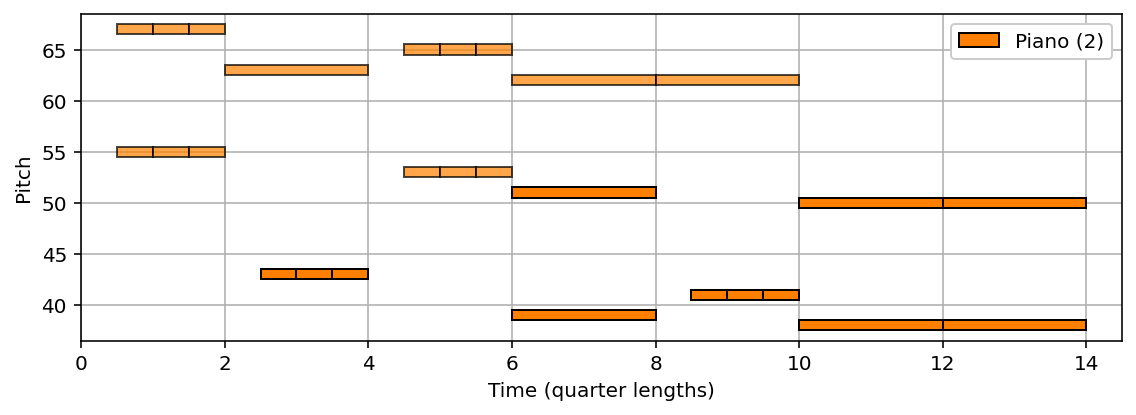

In [16]:
visualize_piano_roll(xml_list, figsize=(8, 3), velocity_alpha=True,
                               xlabel='Time (quarter lengths)');

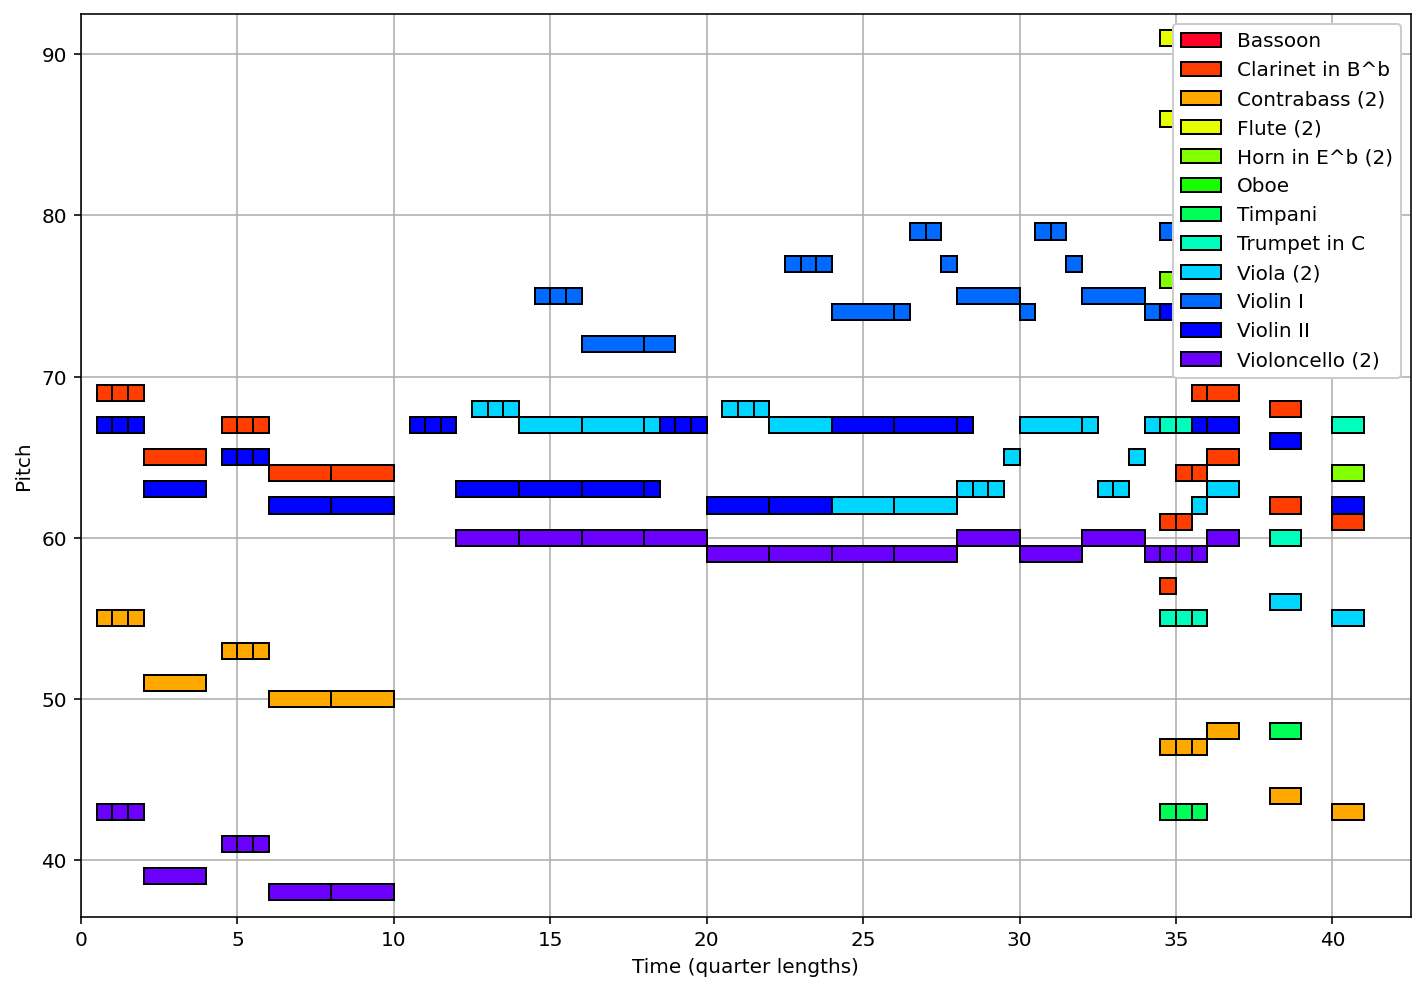

In [17]:
xml_data = m21.converter.parse("../data_FMP/FMP_C1_F10_Beethoven_Fifth-MM1-21_Sibelius-Orchestra.xml")
xml_list = xml_to_list(xml_data)

visualize_piano_roll(xml_list, figsize=(10, 7), velocity_alpha=False,
                               colors='gist_rainbow', xlabel='Time (quarter lengths)');

출처: https://musicinformationretrieval.com/, (https://www.audiolabs-erlangen.de/FMP)

기호 음악 표현법을 사용하는 파이썬 라이브러리
- `PrettyMIDI`: MIDI 읽기, 컨버팅 등
- `music21`: musicxml파일 다루기
- `pypianoroll`: 피아노롤 비주얼